# ALGORITHM OF ANALYSIS AND CLUSTERIZATION OF THERMOGRAPHIC IMAGES 'FLIR'- Developed at Unesp.

## Objective of the project
#### The code solves the group analysis of data taken with a "FLIR" thermograph. The objective of this code is a tool that processes hundreds of thermal images from an experiment conducted on birds of different ages, the images are treated in the following processes:
- Import metadata from FLIR camera.
- Convert the image to a raster image.
- Sample or crop the raster image.
- Clusterize the sample image with Kmeans.
- Statistical analysis of the clustered image.
- Export the results in '.csv' format.

## First part
### Employee library

In [1]:
import flirimageextractor
from matplotlib import cm
import gdal
import numpy as np
from numpy import *
from gdalconst import *
from osgeo import osr
import matplotlib
import georasters as gr
import os
import matplotlib.pyplot as plt
from sklearn import cluster
from osgeo import gdal, gdal_array
import pandas as pd
from PIL import Image
import glob

### Creation of temporary lists to store the processed variables of the data.

In [2]:
List_Temp=[]
List_Temp2=[]
List_Temp3=[]
List_Temp4=[]
List_Temp5=[]
List_Temp6=[]
List_Temp7=[]
List_Temp8=[]
List_Temp9=[]
List_Temp10=[]
List_Temp11=[]
List_Temp12=[]

- Creation of a list of all the thermal images contained in the folder.
- Extraction of the images metadata to save them later in arrangements.
- Save the fixes in "List_Temp".

In [3]:
for filename in glob.glob('Imagenes Exp/*.jpg'):
    flir=flirimageextractor.FlirImageExtractor(palettes=[cm.jet, cm.bwr, cm.gist_ncar])
    flir.process_image(filename)
    Temperaturas=flir.get_thermal_np()
    List_Temp.append(Temperaturas)

## Second part
- Function for generating raster images from the arrangements saved in "List_Temp".

In [4]:
def CreateGeoTiff(Name, Array, driver, NDV, xsize, ysize, GeoT, Projection, DataType):
    if DataType == 'Float32':
        DataType = gdal.GDT_Float32
    NewFileName = Name+'.tif'
    Array[np.isnan(Array)] = NDV
    DataSet = driver.Create( NewFileName, xsize, ysize, 1, DataType )
    DataSet.SetGeoTransform(GeoT)
    DataSet.SetProjection( Projection.ExportToWkt() )
    DataSet.GetRasterBand(1).WriteArray( Array )
    DataSet.GetRasterBand(1).SetNoDataValue(NDV)
    return NewFileName

- Scale the raster image to 160x120 pixels.
- Georeference the image in ".tif" format.
- Save the georeferenced and scaled image in "List_Temp3".

In [5]:
for Temperaturas2 in List_Temp:
    NDV=0
    xsize=160
    ysize=120
    GeoT=(0,0,0,0,0,0)
    driver = gdal.GetDriverByName('GTiff')
    DataType = gdal.GDT_Float32
    Projection = osr.SpatialReference()
    Raster_Temperatura = CreateGeoTiff('temperatura_raster2',Temperaturas2, driver, NDV,xsize, ysize, GeoT, Projection,DataType)
    demFile = gr.from_file('temperatura_raster2.tif')
    List_Temp2.append(Raster_Temperatura)
    List_Temp3.append(demFile)

- Show the first image converted to raster format to size the area to be sampled.

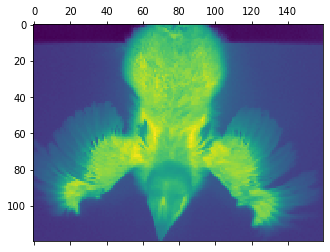

In [6]:
demFile.plot()

## Third part
- Extraction of the spatial metadata from the raster image to later transfer it to the image to be sampled.

In [7]:
for Temperaturas3 in List_Temp2:
    NDV, xsize, ysize, GeoT, Projection, DataType = gr.get_geo_info(Temperaturas3)


- Cut and scale the spatial metadata extracted from the total image, and then copy it later in the sampled image.

In [8]:
for Temperaturas4 in List_Temp3:
    demFileSli = gr.GeoRaster(Temperaturas4.raster[15:40,75:90], GeoT,projection=Projection,nodata_value=NDV)
    List_Temp4.append(demFileSli)


- Convert to raster image in ".tiff" format
- Save the data of the raster images in "List_Temp4-5-6".

In [9]:
for Temperaturas5 in List_Temp4:
    Temperaturas5.to_tiff('Raster_cortado')
    Cortado = Temperaturas5.raster.data[:,:]
    Cortado3=np.ravel(Cortado)
    Cortado2=Cortado3.tolist()
    List_Temp5.append(Cortado)
    List_Temp6.append(Cortado2)

- Show the sampled image.

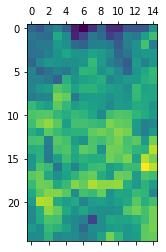

In [10]:
Temperaturas5.plot()

## Fourth part
- Convert the sampled image into an arrangement.

In [11]:
gdal.UseExceptions()
gdal.AllRegister()
img_ds = gdal.Open('Raster_cortado.tif', gdal.GA_ReadOnly)
band = img_ds.GetRasterBand(1)

- Clusterize the arrangement of the sampled image.
- Save the cluster data in "List_Temp7".

In [12]:
for CortadoA in List_Temp5:
    X = CortadoA.reshape((-1,1))
    k_means = cluster.KMeans(n_clusters=3)
    k_means.fit(X)
    X_cluster = k_means.labels_
    X_cluster = X_cluster.reshape(CortadoA.shape)
    List_Temp7.append(X_cluster)

- Extract the data according to the cluster "df_name" of 'Clase'.
- Save the data of "df_name" in a temporary list "List_Temp8".

In [13]:
for CortadoB in List_Temp7:
    Cortado10=np.ravel(CortadoB)
    Cortado11=Cortado10.tolist()
    data = np.mat(Cortado11).reshape(1, int(np.prod(np.mat(Cortado11).shape) )).T
    df1 = pd.DataFrame(data)
    df_name = df1.rename({ 0 : 'Clase'}, axis=1)
    List_Temp8.append(df_name)

- Extract the data according to the cluster "df_name2" of 'Temperatura'.
- Save the data of "df_name" in a temporary list "List_Temp9".

In [14]:
for CortadoC in List_Temp6:
    data2 = np.mat(CortadoC).reshape(1, int(np.prod(np.mat(CortadoC).shape) )).T
    df2 = pd.DataFrame(data2)
    df_name2 = df2.rename({ 0 : 'Temperatura'}, axis=1)
    List_Temp9.append(df_name2)

- Combine in a list the 'Class' and 'Temperatura'.
- Save in a temporary list "List_Temp10".

In [15]:
for AA, BB in zip(List_Temp8, List_Temp9):
    df_colF = pd.concat([AA,BB], axis=1)
    List_Temp10.append(df_colF) 

- Calculations of statistical measures according to the Cluster they belong to.
- Organize the calculated data in rows and columns.

In [16]:
for df_col in List_Temp10:
    #Cluster 0
    s = 0
    df_clase0 = df_col[df_col['Clase'] == s]
    df_count0=df_clase0['Temperatura'].count()
    #Cluster 1
    s = 1
    df_clase1 = df_col[df_col['Clase'] == s]
    df_count1=df_clase1['Temperatura'].count()
    #cluster 2
    s = 2
    df_clase2 = df_col[df_col['Clase'] == s]
    df_count2=df_clase2['Temperatura'].count()
    #Variables para el cluster 0
    df_max0=df_clase0['Temperatura'].max()
    df_min0=df_clase0['Temperatura'].min()
    df_mean0=df_clase0['Temperatura'].mean()
    df_std0=df_clase0['Temperatura'].std()
    porc_0=(df_count0/(df_count0+df_count1+df_count2))*100
    #Variables para luster 1
    df_max1=df_clase1['Temperatura'].max()
    df_min1=df_clase1['Temperatura'].min()
    df_mean1=df_clase1['Temperatura'].mean()
    df_std1=df_clase1['Temperatura'].std()
    porc_1=(df_count1/(df_count0+df_count1+df_count2))*100
    #Variables para cluster 2
    df_max2=df_clase2['Temperatura'].max()
    df_min2=df_clase2['Temperatura'].min()
    df_mean2=df_clase2['Temperatura'].mean()
    df_std2=df_clase2['Temperatura'].std()
    porc_2=(df_count2/(df_count0+df_count1+df_count2))*100
    #Cluster 0
    df_0=(df_max0,df_min0,df_mean0,df_std0,porc_0)
    #Cluster 1
    df_1=(df_max1,df_min1,df_mean1,df_std1,porc_1)
    #Cluster 2
    df_2=(df_max2,df_min2,df_mean2,df_std2,porc_2)
    #Union de todos las columnas de Dataframe
    super_chicken=df_0,df_1,df_2
    List_Temp12.append(super_chicken)

- Save the data obtained in '.csv' format.

In [17]:
#List_Temp12
fox = pd.DataFrame(List_Temp12) 
fox.to_csv('result.csv', sep=',', index=False)